# RAG of internal documents with LLM (Google PaLM) and LangChain, for a Question/Answer system (e.g. "Fact Pack") 


## Overview

With plenty of OpenAI's implementations (e.g. text-embedding-3-small), this one implements Google PaLM's text-bison@002 with LangChain. 

The example is to build a Question Answering system, with prompt engineering (of course) + augmenting the LLM's knowledge with data sources such as documents curated internally. 

Specifically, the Retrieval Augmented Generation (RAG) is based on a private collection of documents (sample of Google published research papers stored on gs://github-repo/documents/google-research-pdfs/). 

Furthermore, it prevents hallucination in two ways:
1. Provide answers with references to the sources 
2. Say "I don't know" rather than hallucination, such as in the case of being asked "what is NFC" where no information is provided in the documents, the system shall not hallucinate. 

## Steps
Ingest knowledge-base sources into a vector store:
1. Read the documents, in this case, PDF files
2. Chunk the documents, to include relevant parts of the document as context to the prompt
3. Generate embeddings for each chunked document
4. Add embedding to the vector store

When user enters a prompt:
1. Raise the question 
2. Generate embedding for the user prompt 
3. Search the vector store to retrieve the nearest embeddings (relevant documents) closer to the prompt
4. Fetch the actual text for the retrieved embeddings to add as context to the user's prompt
5. Add the retrieved documents as context to the user's prompt
6. Send the updated prompt to the LLM
7. Return a summarized response to the user with references to the sources from the knowledge base

## Implementation 
1. Google's PaLM API through Vertex AI with LangChain RetrievalQA 
2. Extract text from PDF files, as stored on Cloud Storage bucket
3. Generate embeddings 
4. Vector Search (previously Vertex AI Matching Engine - and, hehe, Google hasn't completed re-branding)
5. Query and return relevant results
6. Google PaLM API for Text as LLM to synthesize results and respond to the user query

---

## Step 0: Getting Started

### Install requisites: Google Vertex AI, LangChain and dependencies

In [1]:
! pip install --user --upgrade google-cloud-aiplatform==1.47.0 langchain==0.1.14 langchain-google-vertexai==0.1.3 typing_extensions==4.9.0

# Dependencies required by Unstructured PDF loader
! sudo apt -y -qq install tesseract-ocr libtesseract-dev
! sudo apt-get -y -qq install poppler-utils
! pip install --user --upgrade unstructured==0.12.4 pdf2image==1.17.0 pytesseract==0.3.10 pdfminer.six==20221105
! pip install --user --upgrade pillow-heif==0.15.0 opencv-python==4.9.0.80 unstructured-inference==0.7.24 pikepdf==8.13.0 pypdf==4.0.1

# For Matching Engine integration dependencies (default embeddings)
! pip install --user --upgrade tensorflow_hub==0.16.1 tensorflow_text==2.15.0

libtesseract-dev is already the newest version (4.1.1-2.1).
tesseract-ocr is already the newest version (4.1.1-2.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
  Using cached pdfminer.six-20221105-py3-none-any.whl.metadata (4.0 kB)
Using cached pdfminer.six-20221105-py3-none-any.whl (5.6 MB)
  Attempting uninstall: pdfminer.six
    Found existing installation: pdfminer.six 20231228
    Uninstalling pdfminer.six-20231228:
      Successfully uninstalled pdfminer.six-20231228
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdfplumber 0.11.0 requires pdfminer.six==20231228, but you have pdfminer-six 20221105 which is incompatible.
  Using cached pdfminer.six-20231228-py3-none-any.whl.metadata (4.2 kB)
Using cached pdfminer.six-20231228-py3-none-any.whl (5.6 MB)
  Attempting uninstall: pdfminer.six
    Found existing installation: pdfminer.six 2

### Import libraries

In [2]:
import json
import textwrap

# Utils
import time
import uuid
from typing import List

import numpy as np
import vertexai

# Vertex AI
from google.cloud import aiplatform

print(f"Vertex AI SDK version: {aiplatform.__version__}")

# LangChain
import langchain

print(f"LangChain version: {langchain.__version__}")

from langchain.chains import RetrievalQA
from langchain.document_loaders import GCSDirectoryLoader
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import custom Matching Engine packages
from langchain_google_vertexai import (
    VertexAI,
    VertexAIEmbeddings,
    VectorSearchVectorStore,
)

Vertex AI SDK version: 1.47.0
LangChain version: 0.1.14


In [3]:
PROJECT_ID = "genai-423417" 
REGION = "us-central1"  

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=REGION)

### Initialize LangChain Models

Use PaLM `text-bison@002` to initialize LangChain with the pre-trained text. 

FYI, for chat and embeddings generation: use `chat-bison@version-xyz` and `textembedding-gecko@version-xyz` respectively. "Version-xyz" is at https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versioning

In [4]:
# Text model instance integrated with langChain
llm = VertexAI(
    model_name="text-bison@002",
    max_output_tokens=1024,
    temperature=0.2,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Embeddings API integrated with langChain
embeddings = VertexAIEmbeddings(model_name="textembedding-gecko@003")

---

## STEP 1: Create Vector Search Index and Endpoint for the eventual retrieval

(I imagine the following code will be out-of-date soon, as `Google Vector Search` is the re-branded name of `Vertex AI Matching Engine`, even though its code still calls `MatchingEngine`.)


[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data as n-dimensional vector, in a space where the locations of those points in space are semantically meaningful. These embeddings can be then used to find similar data points. You can get text embeddings using [Vertex AI Embeddings API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings). These embeddings are managed using a vector database.


[Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) is a Google Cloud managed vector database, which stores data as high-dimensional vectors (embeddings) and can find the most similar vectors from over a billion vectors. Matching Engine's Approximate Nearest Neigbors (ANN) service can serve similarity-matching queries at high queries per second (QPS). Unlike vector stores that run locally, Matching Engine is optimized for scale (multi-million and billion vectors) and it's an enterprise ready engine.

As part of the environment setup, create an index on Vertex AI Matching Engine and deploy the index to an Endpoint. Index Endpoint can be [public](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public) or [private](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc). This notebook uses a **Public endpoint**.


- Configure parameters to create Matching Engine index
    - `ME_REGION`: Region where Matching Engine Index and Index Endpoint are deployed
    - `ME_INDEX_NAME`: Matching Engine index display name
    - `ME_EMBEDDING_DIR`: Cloud Storage path to allow inserting, updating or deleting the contents of the Index
    - `ME_DIMENSIONS`: The number of dimensions of the input vectors. Vertex AI Embedding API generates 768 dimensional vector embeddings.

In [5]:
ME_REGION = REGION
ME_INDEX_NAME = f"{PROJECT_ID}-me-index"  
ME_EMBEDDING_DIR = f"{PROJECT_ID}-me-bucket"  
ME_DIMENSIONS = 768  

Make a Google Cloud Storage bucket for your Matching Engine index

In [6]:
! set -x && gsutil mb -p $PROJECT_ID -l us-central1 gs://$ME_EMBEDDING_DIR

+ gsutil mb -p genai-423417 -l us-central1 gs://genai-423417-me-bucket
Creating gs://genai-423417-me-bucket/...


### Create Index

For the record, in 2022, I had implemented Google Research: [Accelerating Large-Scale Inference with Anisotropic Vector Quantization](https://arxiv.org/abs/1908.10396).

For more information about how this works, see [Announcing ScaNN: Efficient
Vector Similarity Search](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html).

In [7]:
# NOTE : This operation can take upto 30 seconds
my_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name="langchain-index",
    dimensions=768,
    approximate_neighbors_count=150,
    distance_measure_type="DOT_PRODUCT_DISTANCE",
    index_update_method="STREAM_UPDATE",  # allowed values BATCH_UPDATE , STREAM_UPDATE
)
if my_index:
    print(my_index.name)

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/841470159359/locations/us-central1/indexes/2567812649647603712/operations/5879008993484996608
MatchingEngineIndex created. Resource name: projects/841470159359/locations/us-central1/indexes/2567812649647603712
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/841470159359/locations/us-central1/indexes/2567812649647603712')
2567812649647603712


### Deploy Index to Endpoint

In [8]:
# Create an endpoint
index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=f"langchain-index-endpoint", public_endpoint_enabled=True
)
if index_endpoint:
    print(f"Index endpoint resource name: {index_endpoint.name}")
    print(
        f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}"
    )

Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344/operations/6429574047931039744
MatchingEngineIndexEndpoint created. Resource name: projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344')
Index endpoint resource name: 396092466836537344
Index endpoint public domain name: 1354660318.us-central1-841470159359.vdb.vertexai.goog


In [9]:
# Deploy Index to endpoint
# NOTE : This operation can take upto 20 minutes
my_index_endpoint = index_endpoint.deploy_index(
    index=my_index, deployed_index_id="langchain_index_endpoint_deployed_index"
)

my_index_endpoint.deployed_indexes

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344/operations/5928548589386072064
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/841470159359/locations/us-central1/indexEndpoints/396092466836537344


[id: "langchain_index_endpoint_deployed_index"
index: "projects/841470159359/locations/us-central1/indexes/2567812649647603712"
create_time {
  seconds: 1715968357
  nanos: 137595000
}
index_sync_time {
  seconds: 1715969294
  nanos: 428142000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

---

## STEP 2: Add Document Embeddings to Matching Engine - Vector Store

This step ingests and parse PDF documents, split them, generate embeddings and add the embeddings to the vector store. The document corpus used as dataset is a sample of Google published research papers across different domains - large models, traffic simulation, productivity etc.

### Ingest PDF files

The document corpus is hosted on Cloud Storage bucket (at `gs://github-repo/documents/google-research-pdfs/`) and LangChain provides a convenient document loader [`GCSDirectoryLoader`](https://python.langchain.com/en/latest/modules/indexes/document_loaders/examples/google_cloud_storage_directory.html) to load documents from a Cloud Storage bucket. The loader uses `Unstructured` package to load files of many types including pdfs, images, html and more.

Make a Google Cloud Storage bucket in your GCP project to copy the document files into.

In [10]:
GCS_BUCKET_DOCS = f"{PROJECT_ID}-documents"
! set -x && gsutil mb -p $PROJECT_ID -l us-central1 gs://$GCS_BUCKET_DOCS

+ gsutil mb -p genai-423417 -l us-central1 gs://genai-423417-documents
Creating gs://genai-423417-documents/...


Copy document files to your bucket

In [11]:
folder_prefix = "documents/google-research-pdfs/"
!gsutil rsync -r gs://github-repo/documents/google-research-pdfs/ gs://$GCS_BUCKET_DOCS/$folder_prefix

Building synchronization state...
Starting synchronization...
Copying gs://github-repo/documents/google-research-pdfs/a-human-centered-approach-to-developer-productivity.pdf [Content-Type=application/pdf]...
Copying gs://github-repo/documents/google-research-pdfs/a-mixed-methods-approach-to-understanding-user-trust-after-voice-assistant-failures.pdf [Content-Type=application/pdf]...
Copying gs://github-repo/documents/google-research-pdfs/a-mixture-of-expert-approach-to-rl-based-dialogue-management.pdf [Content-Type=application/pdf]...
Copying gs://github-repo/documents/google-research-pdfs/adaptations-of-ux-practice-to-meet-responsible-ai-challenges.pdf [Content-Type=application/pdf]...
\ [4 files][  5.8 MiB/  5.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rsync ... Please
see the -m section under "gsutil help options" for further information
about when 

Load documents and add document metadata such as file name, to be retrieved later when citing the references.

In [12]:
# Ingest PDF files

print(f"Processing documents from {GCS_BUCKET_DOCS}")
loader = GCSDirectoryLoader(
    project_name=PROJECT_ID, bucket=GCS_BUCKET_DOCS, prefix=folder_prefix
)
documents = loader.load()

# Add document name and source to the metadata
for document in documents:
    doc_md = document.metadata
    document_name = doc_md["source"].split("/")[-1]
    # derive doc source from Document loader
    doc_source_prefix = "/".join(GCS_BUCKET_DOCS.split("/")[:3])
    doc_source_suffix = "/".join(doc_md["source"].split("/")[4:-1])
    source = f"{doc_source_prefix}/{doc_source_suffix}"
    document.metadata = {"source": source, "document_name": document_name}

print(f"# of documents loaded (pre-chunking) = {len(documents)}")

Processing documents from genai-423417-documents


/home/jupyter/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `GCSDirectoryLoader` was deprecated in LangChain 0.0.32 and will be removed in 0.3.0. An updated version of the class exists in the langchain-google-community package and should be used instead. To use it run `pip install -U langchain-google-community` and import as `from langchain_google_community import GCSDirectoryLoader`.
  warn_deprecated(


# of documents loaded (pre-chunking) = 20


Verify document metadata

In [13]:
documents[0].metadata

{'source': 'genai-423417-documents/google-research-pdfs',
 'document_name': 'a-human-centered-approach-to-developer-productivity.pdf'}

### Chunk documents

Split the documents to smaller chunks. When splitting the document, ensure a few chunks can fit within the context length of LLM.

In [14]:
# split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
)
doc_splits = text_splitter.split_documents(documents)

# Add chunk number to metadata
for idx, split in enumerate(doc_splits):
    split.metadata["chunk"] = idx

print(f"# of documents = {len(doc_splits)}")

# of documents = 2091


### Configure Matching Engine as Vector Store

Initialize Matching Engine vector store with text embeddings model

In [15]:
# initialize vector store
me = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f"gs://{ME_EMBEDDING_DIR}".split("/")[2],
    embedding=embeddings,
    index_id=my_index.name,
    endpoint_id=index_endpoint.name,
    stream_update=True,
)

### Add documents as embeddings in Matching Engine as index

The document chunks are transformed as embeddings (vectors) using Vertex AI Embeddings API and added to the index with **[streaming index update](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index)**. With Streaming Updates, you can update and query your index within a few seconds.

The original document text is stored on Cloud Storage bucket had referenced by id.

Prepare text and metadata to be added to the vectors

In [16]:
# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
metadatas = [doc.metadata for doc in doc_splits]

Add embeddings to the vector store

**NOTE:** Depending on the volume and size of documents, this step may take time.

In [17]:
for i in range(0, len(texts), 1000):
    me.add_texts(texts[i : i + 1000], metadatas[i : i + 1000])

Upserting datapoints MatchingEngineIndex index: projects/841470159359/locations/us-central1/indexes/2567812649647603712
MatchingEngineIndex index Upserted datapoints. Resource name: projects/841470159359/locations/us-central1/indexes/2567812649647603712
Upserting datapoints MatchingEngineIndex index: projects/841470159359/locations/us-central1/indexes/2567812649647603712
MatchingEngineIndex index Upserted datapoints. Resource name: projects/841470159359/locations/us-central1/indexes/2567812649647603712
Upserting datapoints MatchingEngineIndex index: projects/841470159359/locations/us-central1/indexes/2567812649647603712
MatchingEngineIndex index Upserted datapoints. Resource name: projects/841470159359/locations/us-central1/indexes/2567812649647603712


Validate semantic search with Matching Engine is working

In [18]:
# Test whether search from vector store is working
me.similarity_search("What are video localized narratives?", k=2)

[Document(page_content='Abstract\n\nWe propose Video Localized Narratives, a new form of multimodal video annotations connecting vision and lan- guage. In the original Localized Narratives [40], annota- tors speak and move their mouse simultaneously on an im- age, thus grounding each word with a mouse trace segment. However, this is challenging on a video. Our new protocol empowers annotators to tell the story of a video with Local- ized Narratives, capturing even complex events involving multiple actors interacting with each other and with sev- eral passive objects. We annotated 20k videos of the OVIS, UVO, and Oops datasets, totalling 1.7M words. Based on this data, we also construct new benchmarks for the video narrative grounding and video question answering tasks, and provide reference results from strong baseline models. Our annotations are available at https://google. github.io/video-localized-narratives/.', metadata={'source': 'genai-423417-documents/google-research-pdfs', 'doc

In [19]:
me.similarity_search("What is NFC?", k=2, search_distance=0.4)

[Document(page_content='<latexit sha1_base64="+t0/fCT+bwdn8UYzdjxaOo9NJME=">AAACPHicfZDLSsNAFIYn9V6v1aWbYBVFpCQi6rKgC12IF2wrNKWcTE/SoZNJmJmINfQN3Orj+B7u3Ylb105rBW94YODjP//MnPP7CWdKO86TlRsZHRufmJzKT8/Mzs0vFBarKk4lxQqNeSyvfFDImcCKZprjVSIRIp9jze8c9Pu1a5SKxeJSdxNsRBAKFjAK2kgXt+vNhaJTcgZl/wZ3CEUyrLNmwVr1WjFNIxSaclCq7jqJbmQgNaMce3kvVZgA7UCIdYMCIlSNbDBqz14zSssOYmmO0PZA/Xojg0ipbuQbZwS6rX72+uJfvXqqg/1GxkSSahT046Mg5baO7f7edotJpJp3DQCVzMxq0zZIoNqkk/cO0ewi8cS8e5qgBB3LzcwDGUZw0zO7hd5Wn/4zMvFpNJQ3ubo/U/wN1e2Su1vaOd8plo+HCU+SZbJCNohL9kiZHJEzUiGUBOSO3JMH69F6tl6s1w9rzhreWSLfynp7By8brgI=</latexit>z0', metadata={'source': 'genai-423417-documents/google-research-pdfs', 'document_name': 'a-mixture-of-expert-approach-to-rl-based-dialogue-management.pdf', 'chunk': 206}),
 Document(page_content='<latexit sha1_base64="mPpLqvfiTr3sYUH3/8vodE3xifA=">AAACPHicfZDLSgMxFIYzXmu969JNsAoiUmakqMuCLnQhXrC10ClyJj3ThmYyQ5IR69A3cKuP43u4dyduXZvWCt7wQODjP3+Sc/4gEVwb131yRkbHxicmc1P56ZnZufmFxaWqjlPFsMJiEataABoFl1gx3AisJQohCgReB

---

## STEP 3: Retrieval based Question/Answering Chain

LangChain provides easy ways to chain multiple tasks that can do QA over a set of documents, called QA chains. The notebook works with [**RetrievalQA**](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) chain which is based on **load_qa_chain** under the hood.

In the retrieval augmented generation chain, the Matching Engine uses semantic search to retrieve relevant documents based on the user's question. The resulting documents are then added as additional context to the prompt sent to the LLM, along with the user's question, to generate a response. Thus the response generated by LLM is grounded to your documents in the corpus.

This way, a user would only need to provide their question as a prompt and the retrieval chain would be able to seek the answers using Matching Engine directly, and return a proper text response answering the question.

### Configure Question/Answering Chain with Vector Store using Text

Define Matching Engine Vector Store as retriever that takes in a query and returns a list of relevant documents. The retriever implementation supports configuring number of documents to fetch and filtering by search distance as a threshold value parameter.

In [20]:
# Create chain to answer questions
NUMBER_OF_RESULTS = 10
SEARCH_DISTANCE_THRESHOLD = 0.6

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": NUMBER_OF_RESULTS,
        "search_distance": SEARCH_DISTANCE_THRESHOLD,
    },
    filters=None,
)

Customize the default retrieval prompt template

In [21]:
template = """SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: {question}

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

=============
{context}
=============

Question: {question}
Helpful Answer:"""

Configure RetrievalQA chain

In [22]:
# Uses LLM to synthesize results from the search index.
# Use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    },
)

Enable verbose logging for debugging and troubleshooting the chains which includes the complete prompt to the LLM

In [23]:
# Enable for troubleshooting
qa.combine_documents_chain.verbose = True
qa.combine_documents_chain.llm_chain.verbose = True
qa.combine_documents_chain.llm_chain.llm.verbose = True

Utility function to format the result

In [24]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("." * 80)
    if "source_documents" in result.keys():
        for idx, ref in enumerate(result["source_documents"]):
            print("-" * 80)
            print(f"REFERENCE #{idx}")
            print("-" * 80)
            if "score" in ref.metadata:
                print(f"Matching Score: {ref.metadata['score']}")
            if "source" in ref.metadata:
                print(f"Document Source: {ref.metadata['source']}")
            if "document_name" in ref.metadata:
                print(f"Document Name: {ref.metadata['document_name']}")
            print("." * 80)
            print(f"Content: \n{wrap(ref.page_content)}")
    print("." * 80)
    print(f"Response: {wrap(result['result'])}")
    print("." * 80)


def wrap(s):
    return "\n".join(textwrap.wrap(s, width=120, break_long_words=False))


def ask(
    query,
    qa=qa,
    k=NUMBER_OF_RESULTS,
    search_distance=SEARCH_DISTANCE_THRESHOLD,
    filters={},
):
    qa.retriever.search_kwargs["search_distance"] = search_distance
    qa.retriever.search_kwargs["k"] = k
    qa.retriever.search_kwargs["filters"] = filters
    result = qa({"query": query})
    return formatter(result)

### Run QA chain on sample questions

Following are sample questions you could try. Wehn you run the query, RetrievalQA chain takes the user question, call the retriever to fetch top *k* semantically similar texts from the Matching Engine Index (vector store) and passes to the LLM as part of the prompt. The final prompt sent to the LLM looks of this format:

```
SYSTEM: {system}

=============
{context}
=============

Question: {question}
Helpful Answer:
```

where:
 - `system`: Instructions for LLM on how to respond to the question based on the context
 - `context`: Semantically similar text (a.k.a snippets) retreived from the vector store
 - `question`: question posed by the user


The response returned from the LLM includes both the response and references that lead to the response. This way the response from LLM is always grounded to the sources. Here we have formatted the response as:

```
Question: {question}
--------------------------------------------------------------------------------
REFERENCE #n
--------------------------------------------------------------------------------
Matching Score: <score>
Document Source: <document source location>
Document Name: <document file name>
................................................................................
Context:
{}
................................................................................
Response: <answer returned by the LLM>
................................................................................
```

In [25]:
ask("What are video localized narratives?")

/home/jupyter/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What are video localized narratives?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

Abstract

We propose Video Localized Narratives, a new form of multimodal video annotations connecting vision and lan- guage. In the original Localized Narratives [40], annota- tors speak and move their mouse simultaneously on an im- age, thus grounding each word with a mouse trace segment. However, this is challenging on a video. Our new protocol empow

- Let's try the same question filtering on a specific document. Note that the document used in the filter does not address the question. Refer to [Vertex AI Vector Search documentation](https://cloud.google.com/vertex-ai/docs/vector-search/filtering) for the filter syntax.

In [26]:
filters = {
    "namespace": "document_name",
    "allow_list": ["detecting-news-headline-hallucinations-with-explanations.pdf"],
}
ask("What are video localized narratives?", filters=filters)



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What are video localized narratives?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

Abstract

We propose Video Localized Narratives, a new form of multimodal video annotations connecting vision and lan- guage. In the original Localized Narratives [40], annota- tors speak and move their mouse simultaneously on an im- age, thus grounding each word with a mouse trace segment. However, this is challenging on a video. Our new protocol empow

In [27]:
ask("What is annotator diversity?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What is annotator diversity?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

According to the survey results, a significant majority of respon- dents (75%) considered diversity to be a somewhat to extremely influential factor (>=3 on the Likert scale) in the quality of their annotated datasets. However, despite the perceived importance of various individual attributes and characteristics of annotators, very few of these factors were uti

In [28]:
ask("What are challenges in creating a realistic simulation of city traffic?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What are challenges in creating a realistic simulation of city traffic?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

. Unfortunately, there is no reproducible process to create accurate demand data as of now, which is where most of the major challenges of realistic traffic simulation remain. However, demand data accuracy can still be slightly improved through calibration against ground data (Section 7).

CALIBRATION The challenges of

In [29]:
ask("What is standard contrastive learning?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What is standard contrastive learning?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

There have been a number of other attempts to unify different contrastive learning techniques in a single theoretical framework. Balestriero & LeCun (2022) describe a uniﬁcation using the framework of spectral embedding methods, and draw connections between SimCLR and Kernel ISOMAP. Tian (2022) provides a game-theoretic uniﬁcation, and shows that cont

In [30]:
ask("What affects engineering productivity?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What affects engineering productivity?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

Conflating throughput with pro- ductivity: One might count the lines of code written by a devel- oper in a certain period and cal- culate a simple output per unit time “productivity” measure like lines of code per minute. Pounds of coal shoveled per hour will tell you which shovelers are the best shovelers; lines of code per minute will not tell you w

In [31]:
ask("Why are humans preferred as software developers?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: Why are humans preferred as software developers?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

There are two good reasons to think of developers as humans. First, developers strongly prefer that their humanity is acknowledged and re- spected (a key indicator of their hu- manity, in fact, is their preference for others to recognize it). Second, if we want to understand what makes devel- opers more or less productive, we need to underst

In [32]:
ask("How does semantic parsing work with low resource languages?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: How does semantic parsing work with low resource languages?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

2 Background

In this section, we provide an overview of semantic parsing and prior translation-based methods for creating multilingual semantic parsing datasets.

2.1 Semantic Parsing

Semantic parsing is the task of mapping text queries to their meaning representations or logical forms (Zelle and Mooney, 1996; Zettlemoyer and Co

Let's ask a question which is outside of the domain in the corpus. You should see something like - "I cannot determine the answer to that". This is because the output is conditioned in the prompts to not to respond when the question is out of the context.

Following is the instructions in prompt template that is configured in the retrieval QA chain above:

```
Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."
```

In [33]:
ask("What is NFC?")



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: What is NFC?

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

<latexit sha1_base64="+t0/fCT+bwdn8UYzdjxaOo9NJME=">AAACPHicfZDLSsNAFIYn9V6v1aWbYBVFpCQi6rKgC12IF2wrNKWcTE/SoZNJmJmINfQN3Orj+B7u3Ylb105rBW94YODjP//MnPP7CWdKO86TlRsZHRufmJzKT8/Mzs0vFBarKk4lxQqNeSyvfFDImcCKZprjVSIRIp9jze8c9Pu1a5SKxeJSdxNsRBAKFjAK2kgXt+vNhaJTcgZl/wZ3CEUyrLNmwVr1WjFNIxSaclCq7jqJbmQgNaMce3kvVZgA7UCIdYMCIlSNbDBqz14zSssOYmmO0PZA/Xojg0ipbuQbZwS6rX72+uJfvXqqg/1GxkSSahT

## Fact Pack!

### Situation 
Extract succinct insight is the bedrock of financial services and knowledge-based industries, where proprietary research Involves grueling study of voluminous financial filings, earnings and news releases, public/private/proprietary sources of the target,

### Challenge
Find needles from mountains of documents with predefined formats to surface actionable/hidden insights, i.e. in case of SEC 10k 
1. Business overview vs. synthesized summarization
2. Sections of “Risk factors”, “Management’s discussion and analysis” vs. key insights and breakdown items

### Resolution 
Generative AI to produce LLM synthesized summary and key takeaway headers for potential opportunity and target scans, drill down to revenue, customer/segment with risk and shift, etc.


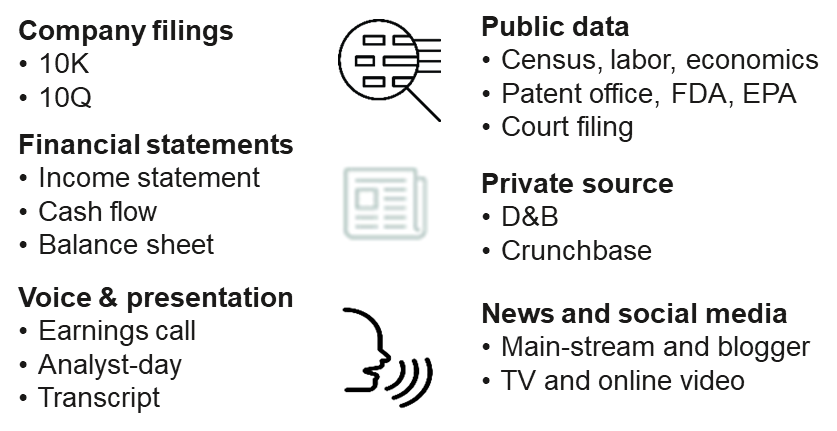

-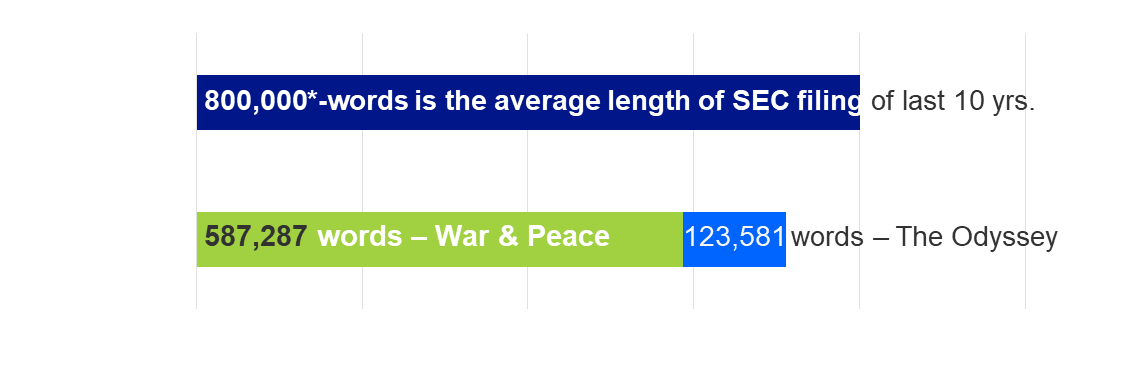--